# Analyzing, Visualizing & Classifying Fake & Real News Data with Logistic Regression

In this project, we aim to analyze and visualize news data before predicting whether the article is fake or real news. We will be using Logistic Regression for classification purposes since it's good at text-classifying. Data used can be found [here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset).

The data is split into two datasets, containing 44898 articles in total. The columns include:

* title: Contains the title of each article.
* text: Contains the context of each article.
* subject: Contains the subject of each article.
* date: Contains the date each article was posted in a Month DD, YYYY format.

## 1. Reading the data in

We will not be using the text column for this project. For other columns, we will be familiarizing ourselves with them in this step. Let's import, concatenate and explore the datasets.

In [1]:
import pandas as pd
import numpy as np
import re
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

warnings.simplefilter(action='ignore', category=Warning)
pd.options.mode.chained_assignment = None

In [2]:
fake = pd.read_csv("Fake.csv", usecols=["title", "subject", "date"]).copy()
real = pd.read_csv("True.csv", usecols=["title", "subject", "date"]).copy()

In [3]:
fake["label"] = "fake"
real["label"] = "real"
fake.head()

,title,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,News,"December 25, 2017",fake


In [4]:
real.head()

,title,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",politicsNews,"December 31, 2017",real
1,U.S. military to accept transgender recruits o...,politicsNews,"December 29, 2017",real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,politicsNews,"December 31, 2017",real
3,FBI Russia probe helped by Australian diplomat...,politicsNews,"December 30, 2017",real
4,Trump wants Postal Service to charge 'much mor...,politicsNews,"December 29, 2017",real


We have labelled the data, we can now combine the datasets. We will do sampling on the entire dataset after combining with a seed. We will use the seed "1" for the random number generator for reproducable results.

In [5]:
news = pd.concat([fake, real], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)
news.head()

,title,subject,date,label
0,Trump Calls For This Racist Policy To Be Forc...,News,"September 21, 2016",fake
1,Republican ex-defense secretary Cohen backs Hi...,politicsNews,"September 7, 2016",real
2,"TEACHER QUITS JOB After 5th, 6th Grade Muslim ...",politics,"May 9, 2017",fake
3,LAURA INGRAHAM RIPS INTO THE PRESS…Crowd Goes ...,politics,"Jul 21, 2016",fake
4,Germany's Merkel suffers state vote setback as...,worldnews,"October 14, 2017",real


In [6]:
news.label.value_counts(dropna=False)

fake    23481
real    21417
Name: label, dtype: int64

Now that we have combined the data, we will first clean and prepare it.

## 2. Preprocessing the data

We will first take a look at the columns subject and date.

In [7]:
news.subject.value_counts(dropna=False)

politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

As we can see, there are no missing values in this column. However, some subject names are written in camel case with others written in snake case and more... We will replace the column names to fix this problem.

In [8]:
news["subject"] = news["subject"].replace({"politicsNews": "Politics",
                                           "worldnews": "World",
                                           "politics": "Politics",
                                           "News": "All",
                                           "left-news": "Left", 
                                           "Government News": "Government",
                                           "US_News": "US",
                                           "Middle-east": "Middle East"})
news.subject.value_counts()

Politics       18113
World          10145
All             9050
Left            4459
Government      1570
US               783
Middle East      778
Name: subject, dtype: int64

We will now take a look at the dates.

In [9]:
news.date.value_counts(dropna=False)

December 20, 2017      182
December 6, 2017       166
November 30, 2017      162
November 9, 2017       158
October 13, 2017       155
                      ... 
December 22, 2017        1
June 24, 2017            1
May 22, 2016             1
January 24, 2016         1
September 11, 2016       1
Name: date, Length: 2397, dtype: int64

As we can see, there are some values which are not dates. We will explore these values.

In [10]:
news[news.date.str.extract(r"^((?!\w+ \d+, \d+))*", expand=False).notnull()]

,title,subject,date,label
328,JUST IN: CROOKED DOJ OFFICIAL Didn’t Reveal Th...,Politics,14-Feb-18,fake
1352,LOCAL REPORTER IN DEEP BLUE STATE Stuns Libera...,Politics,17-Feb-18,fake
1883,JUST IN: BADASS GENERAL JOHN KELLY Shoved Chin...,Politics,18-Feb-18,fake
5157,https://fedup.wpengine.com/wp-content/uploads/...,Government,https://fedup.wpengine.com/wp-content/uploads/...,fake
5295,https://fedup.wpengine.com/wp-content/uploads/...,Left,https://fedup.wpengine.com/wp-content/uploads/...,fake
7127,"HEY, BERNIE SANDERS: 18 SCHOOL SHOOTINGS Have ...",Politics,16-Feb-18,fake
8116,IT BEGINS…RINO MEGA-DONOR Threatens Jeb Bush: ...,Politics,18-Feb-18,fake
8554,“PROUD TRANSGENDER” Democrat Candidate For Con...,Politics,15-Feb-18,fake
8567,FACEBOOK’S VP Of Ads BLASTS MEDIA: Majority Of...,Politics,17-Feb-18,fake
8768,BUSTED! Maxine Waters’ Ties to Black Nationali...,Politics,18-Feb-18,fake


Here are some observations about our recent exploration:

* The articles that have falsely formatted dates and other values for dates are all labelled fake.
* They are mostly about politics.

What we will do is, we will replace these values with null values.

In [11]:
news.loc[news.date.str.extract(r"^((?!\w+ \d+, \d+))*", expand=False).notnull(), "date"] = np.nan

In [12]:
news[news.date.isnull()].shape[0]

45

Before classification, we will visualize our data to see if we're missing anything so far. We will do some further preprocessing later on.

## 3. Visualizing the data for gaining further insights

We will now visualize and analyze the data we have to see if there are any patterns we might be missing. We will begin with visualizing the time series data for frequencies of fake vs. real news articles.

In [13]:
news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   subject  44898 non-null  object
 2   date     44853 non-null  object
 3   label    44898 non-null  object
dtypes: object(4)
memory usage: 1.4+ MB


Text(0, 0.5, 'Count')

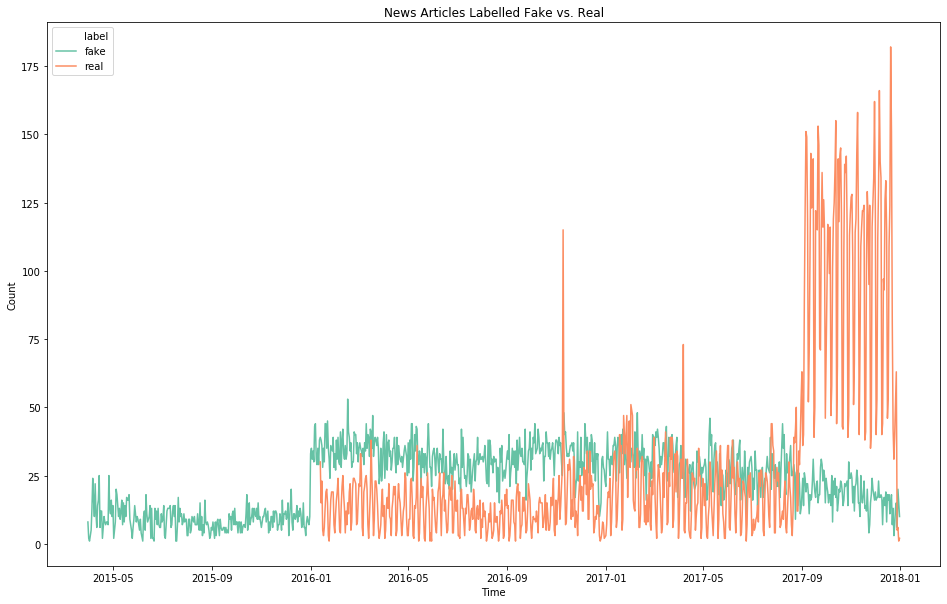

In [14]:
news.date = pd.to_datetime(news.date, errors="coerce")
news_grouped = news[["date", "subject", "label"]].groupby(["date", "label"]).count().reset_index()

fig, ax = plt.subplots(figsize=(16,10))
sns.lineplot(x="date", y="subject", hue="label", data=news_grouped, palette="Set2", ax=ax)
plt.title("News Articles Labelled Fake vs. Real")
plt.xlabel("Time")
plt.ylabel("Count")

As we are able to see from the line chart above, we have no real news article data prior to the beginning of 2016. However, even after that, the amount of fake news articles is dominating compared to the amount of real news articles for a while. We see a sudden increase in number of real news articles in the last quarter of 2016 followed by another unexpected peak nearing May, 2017. Afterwards, we see a sudden and massive increase in the amount of real articles' data with a more subtle decrease in number of fake articles over time. 

Let's take a look at the subjects.

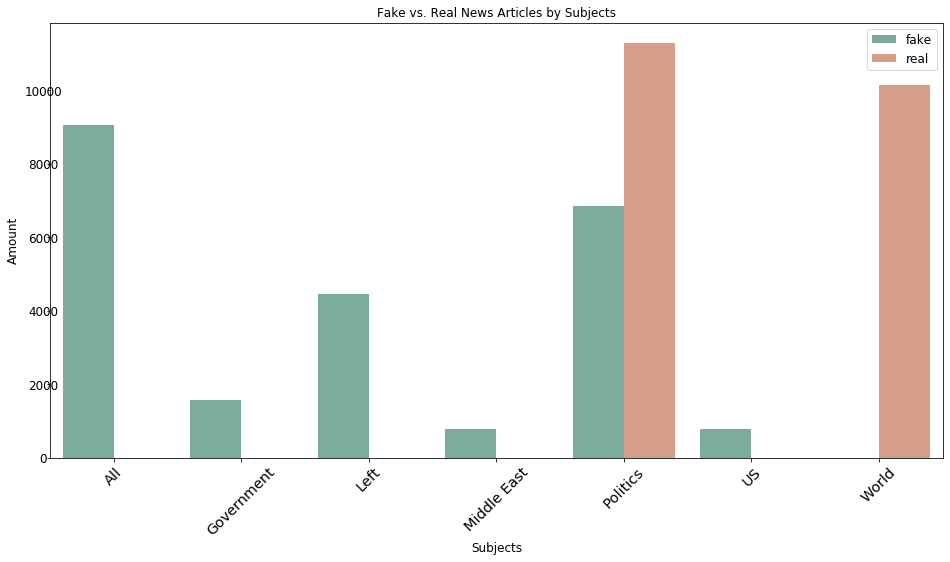

In [15]:
news_group_by_subj_and_label = news.groupby(by=["label", "subject"]).count().reset_index()

fig1, ax1 = plt.subplots(figsize=(16, 8))
sns.barplot(x="subject", y="title", hue="label", data=news_group_by_subj_and_label, palette="Set2", saturation=0.5, ax=ax1)
plt.title("Fake vs. Real News Articles by Subjects")
plt.xticks(rotation=45, horizontalalignment='center', fontweight='light', fontsize='x-large')
plt.yticks(horizontalalignment='center', fontweight='light', fontsize='large')
plt.xlabel("Subjects", fontsize="large")
plt.ylabel("Amount", fontsize="large")
plt.legend(fontsize="large")

As we can see, "real" article group contains articles that have either "Politics" or "World" as their subjects while "fake" articles consist of a variety of subjects. Fake news articles seem to have a tendency to belong into the subject category "All", followed by "Politics" whereas not showing any interest in "World" category. In the meanwhile, real news articles belong into either one of these categories: "Politics" and "World". Both real and fake articles have many articles in "Politics" category. 

## 4. Further Preprocessing

Before we move on to the classification, we will be working on the data further.

Our first step will be dropping some data. We will drop articles that were released before 2016 because there are no real news articles in that period, therefore, the data is not representative enough. Talking about representation, we will also be dropping articles from subjects "Government", "Left", "Middle East" and "US". That's because the only common subject both fake and real articles have is "Politics" and we will be dropping too much data if we drop articles with "All" and "World" subjects. Also, their frequencies and names also indicate that the "All" subject for fake articles might be the equivalent of the "World" subject in real news. 

In [16]:
news_clean = news[news.date > dt.datetime(2016,1,1)]
news_clean.date.value_counts().sort_index()

2016-01-02    35
2016-01-03    31
2016-01-04    34
2016-01-05    30
2016-01-06    43
              ..
2017-12-27    78
2017-12-28    11
2017-12-29    26
2017-12-30    16
2017-12-31    12
Name: date, Length: 730, dtype: int64

In [17]:
news_clean = news_clean[news_clean.subject.isin(["All", "Politics", "World"])]
news_clean.subject.value_counts()

Politics    16910
World       10145
All          9030
Name: subject, dtype: int64

In [18]:
news_clean.shape[0]

36085

As we can see, we still ended up with a decent amount of data! As a next step, we will be working on our features. 

## 5. Feature Weighting

As our features, we are going to use words in the article titles. We will be assigning weights to these words using term-frequencies of them. We will begin with splitting the dat into training and testing sets.

In [19]:
training_data, testing_data = train_test_split(news_clean, random_state=1) #seed for reproducibility

Y_train = training_data["label"].values
Y_test = testing_data["label"].values

def word_counter(data, column, training_set, testing_set):

    cv = CountVectorizer(binary=False, max_df=0.95)
    cv.fit_transform(training_data[column].values)
    
    train_feature_set = cv.transform(training_data[column].values)
    test_feature_set = cv.transform(testing_data[column].values)
    
    return train_feature_set, test_feature_set, cv

X_train, X_test, feature_transformer = word_counter(news_clean, "title", training_data, testing_data)

## 6. Training the model, prediction & accuracy

Now that we have prepared our features, we will be training our model. Then, we will predict values for our testing set. We will be using the accuracy metric after that. Accuracy is measured using the formula below:

\begin{equation}
\text{Accuracy} = \frac{\text{number of correctly classified articles}}{\text{total number of classified articles}}
\end{equation}

In [20]:
classifier = LogisticRegression(solver="newton-cg", C=5, penalty="l2", multi_class="multinomial", max_iter=1000)
model = classifier.fit(X_train, Y_train)

In [21]:
predictions = model.predict(X_test)
accuracy = accuracy_score(Y_test, predictions, normalize=True)
print("Our model has {}% prediction accuracy.".format(round(accuracy, 2) * 100))

Our model has 96.0% prediction accuracy.


## 7. Conclusion

Through this project, we have cleaned, analyzed, visualized and classified fake and real news articles. 

* We have cleaned our data to prepare it for further analysis.
* Later, we have visualized and analyzed the data before fitting it to make sure that our data is ready.
* We assigned term-frequencies of the words in the title column as their weights while feature weighting.
* We have used Multinomial Logistic Regression for classification and accuracy as our metric. Our model successfully classified 96% of the testing data in the end.